In [3]:
import polars as pl
from pybaseball import statcast_batter
from pybaseball import playerid_lookup
from datetime import datetime

CURRENT_YEAR = datetime.today().year

player = playerid_lookup(first='Shohei', last='Ohtani')
player_batting_stats = pl.from_pandas(statcast_batter('2022-01-01', '2024-12-31', player_id=player.key_mlbam[0]))

Gathering Player Data


In [23]:
player_batting_stats.head(), player_batting_stats.select('description').unique()

(shape: (5, 94)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ pitch_typ ┆ game_date ┆ release_s ┆ release_p ┆ … ┆ delta_hom ┆ delta_run ┆ bat_speed ┆ swing_le │
 │ e         ┆ ---       ┆ peed      ┆ os_x      ┆   ┆ e_win_exp ┆ _exp      ┆ ---       ┆ ngth     │
 │ ---       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ ---      │
 │ str       ┆           ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆           ┆ f64      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ FF        ┆ 2024-05-1 ┆ 91.9      ┆ -1.08     ┆ … ┆ -0.016    ┆ 0.141     ┆ 74.626828 ┆ 7.24196  │
 │           ┆ 5         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
 │ FF        ┆ 2024-05-1 ┆ 91.1      ┆ -1.18     ┆ … ┆ 0.0       ┆ -0.013    ┆ 75.949795 ┆ 6.86218  │
 │           ┆ 5         ┆           ┆           ┆   ┆           ┆

In [86]:
from polars import selectors as cs

lower_limit_strike_zone = 1.5

df = (
    player_batting_stats
    .with_columns(
        pl.col('game_date').cast(pl.Date),

        pl.when(
            pl.col('description')=='swinging_strike',
            pl.col('plate_z')<lower_limit_strike_zone
        ).then(pl.lit('swinging_strike_low'))
        .when(pl.col('plate_z')<lower_limit_strike_zone).then(pl.lit('low_pitch'))
        .when(pl.col('description')=='swinging_strike').then(pl.lit('swinging_strike'))
        .when(pl.col('description')=='swinging_strike_blocked').then(pl.lit('swinging_strike'))
        .otherwise(pl.lit('other'))
        .alias('swinging_strike_flg_2'),
    
        pl.when(pl.col('description')=='swinging_strike').then(pl.lit('swinging_strike'))
        .when(pl.col('description')=='swinging_strike_blocked').then(pl.lit('swinging_strike'))
        .otherwise(pl.lit('other'))
        .alias('swinging_strike_flg'),
        
    )
    .filter(pl.col('game_type')=='R')
    .select(
        'game_year',
        'game_date',
        'description',
        'swinging_strike_flg',
        'swinging_strike_flg_2',
        'plate_x',
        'plate_z',
        pl.col('game_date').rank(method='dense').over('game_year').alias('game_number_in_season')
    )
    .filter(
        pl.col('game_number_in_season')<=pl.col('game_number_in_season').filter(pl.col('game_year')==CURRENT_YEAR).max()
    )
    .sort('swinging_strike_flg')
)

df.head()

game_year,game_date,description,swinging_strike_flg,swinging_strike_flg_2,plate_x,plate_z,game_number_in_season
i64,date,str,str,str,f64,f64,u32
2024,2024-05-15,"""hit_into_play""","""other""","""other""",0.12,2.63,43
2024,2024-05-15,"""foul""","""other""","""other""",0.02,3.76,43
2024,2024-05-15,"""called_strike""","""other""","""low_pitch""",-0.1,1.43,43
2024,2024-05-15,"""ball""","""other""","""other""",-1.49,1.55,43
2024,2024-05-15,"""called_strike""","""other""","""other""",-0.8,1.67,43


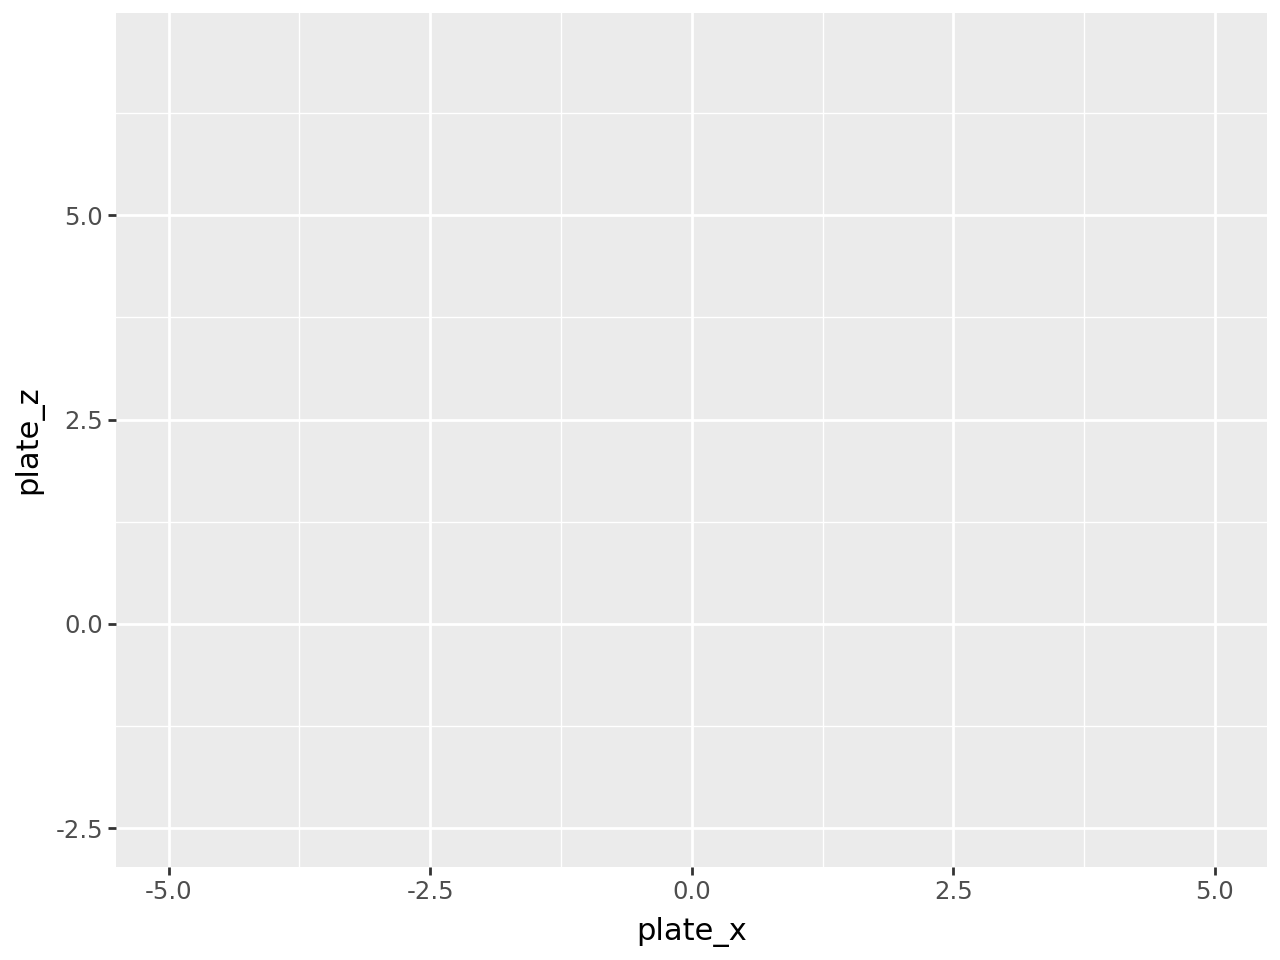

In [87]:
from plotnine import *

strike_zone = (
    geom_rect(
        ymax = 3.5, ymin = 1.5, 
        xmax = -1, xmin = 1, 
        alpha = 0, size=1,
        colour = 'black'
    )
)

pitch_zone_plot = (
    ggplot(df, aes(x='plate_x', y='plate_z'))
    + coord_cartesian(
        xlim = [-5, 5],
        ylim = [-2.5, 7]
    )
)
pitch_zone_plot

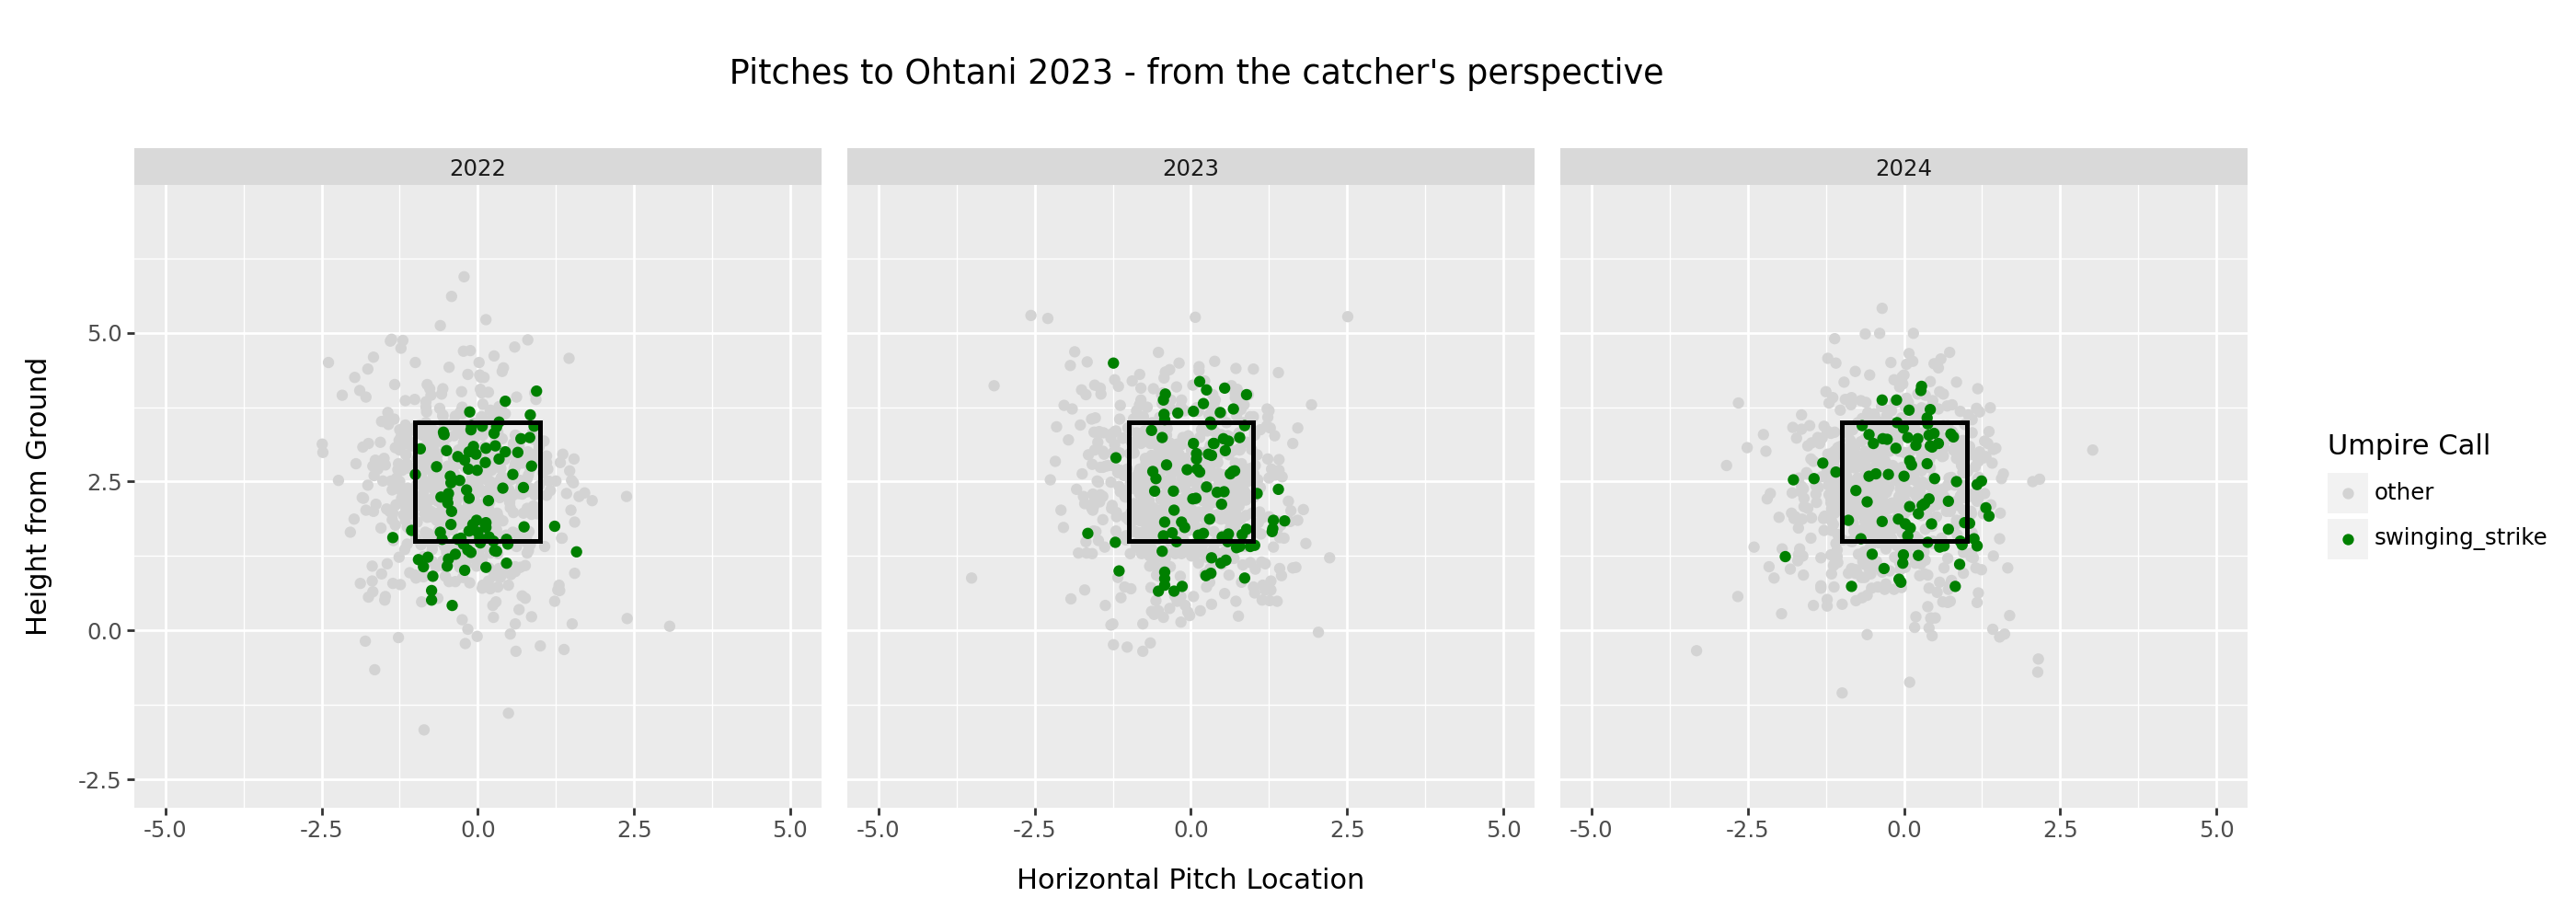

In [88]:
(
    pitch_zone_plot
    + geom_point(aes(color='swinging_strike_flg'))
    + strike_zone
    + facet_wrap('game_year')
    + scale_color_manual(values=['lightgray', 'green'])
    
    + labs(
        title='\n Pitches to Ohtani 2023 - from the catcher\'s perspective\n',
        x='Horizontal Pitch Location', 
        y='Height from Ground',
        color='Umpire Call'
    )
    + theme(figure_size=(14,5))
)

In [89]:
(
    df
    .group_by(
        'game_year',
        'swinging_strike_flg_2'
    )
    .len()
    .pivot(index='game_year',columns='swinging_strike_flg_2', values='len')
    .with_columns(
        pl.sum_horizontal(pl.all()).alias('total_pitches'),
        (
            ( (pl.col('swinging_strike_low') / pl.col('low_pitch')) * 100 )
            .round(1)  
            .cast(pl.Utf8) 
            + '%'
        )
        .alias('swinging_strike_perc_on_low_pitches')
    )
    .with_columns(
        (
            ( (pl.col('low_pitch') / pl.col('total_pitches')) * 100 )
            .round(1)  
            .cast(pl.Utf8) 
            + '%'
        )
        .alias('low_pitch_perc')
    )
    .sort('game_year')
)

game_year,swinging_strike,other,swinging_strike_low,low_pitch,total_pitches,swinging_strike_perc_on_low_pitches,low_pitch_perc
i64,u32,u32,u32,u32,i64,str,str
2022,68,523,19,128,2760,"""14.8%""","""4.6%"""
2023,68,549,20,134,2794,"""14.9%""","""4.8%"""
2024,64,580,14,138,2820,"""10.1%""","""4.9%"""


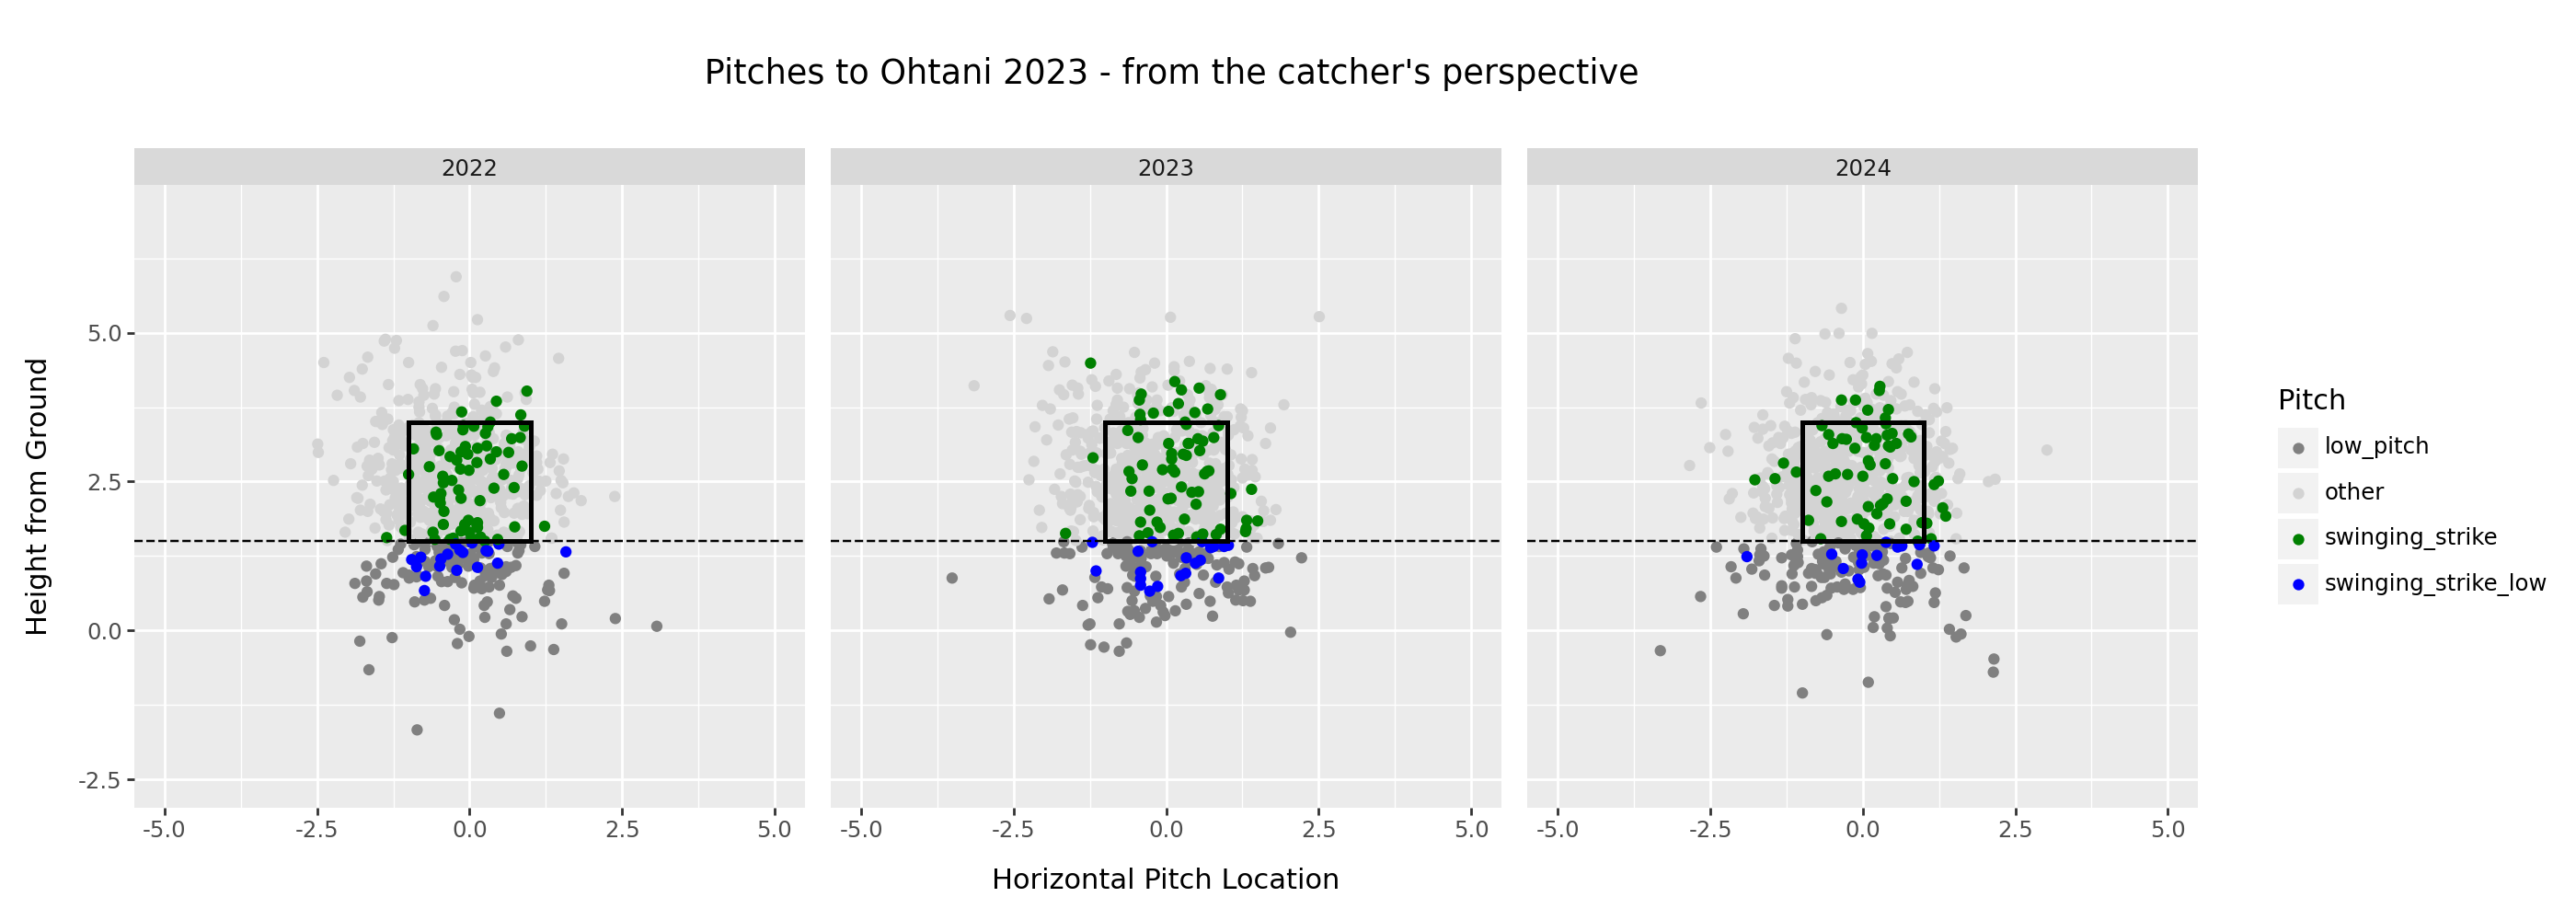

In [98]:
(
    pitch_zone_plot
    + geom_point(aes(color='swinging_strike_flg_2'))
    + strike_zone
    + facet_wrap('game_year')
    + scale_color_manual(values=['gray', 'lightgray', 'green', 'blue'])
    + geom_hline(yintercept=lower_limit_strike_zone, linetype='dashed')
    + labs(
        title='\n Pitches to Ohtani 2023 - from the catcher\'s perspective\n',
        x='Horizontal Pitch Location', 
        y='Height from Ground',
        color='Pitch'
    )
    # + theme_538()
    + theme(figure_size=(14,5))
)